## Greedy search #2

{'black': {'rgb': [0.0, 0.0, 0.0], 'alpha': np.float64(0.18126924692201818)}, 'blue': {'rgb': [0.0, 0.0, 1.0], 'alpha': np.float64(0.28346868942621073)}, 'green': {'rgb': [0.0, 1.0, 0.0], 'alpha': np.float64(0.22119921692859512)}, 'red': {'rgb': [1.0, 0.0, 0.0], 'alpha': np.float64(0.3934693402873666)}, 'white': {'rgb': [1.0, 1.0, 1.0], 'alpha': np.float64(0.1331221002498184)}}
target
[0.0, 0.5, 0.5]
base 30.44926436861716
[0.5, 0.5, 0.5]
black 30.235372978175803
['black']
56.656518064887
0.0
blue 57.3095381900702
['blue']
147.59557174388158
0.0
green 34.217329229038974
['green']
115.17686107739304
0.0
red 75.4000104896094
['red']
132.6664111839566
20.050139020031736
white 32.25578487033703
['white']
59.9606194757669
2.8984534018011288
['black']
black 32.19515247020784
['black', 'black']
56.656518064887
0.0
blue 53.15046123862461
['blue', 'black']
106.40408007523004
0.0
green 28.863153907614556
['green', 'black']
62.519482462043754
0.0
red 69.19885574508127
['red', 'black']
103.8458723

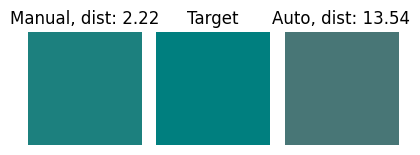

['blue', 'blue', 'blue', 'green', 'green']


C:\Users\Matyanson\AppData\Local\Temp\ipykernel_17168\3735471912.py:137: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle(
C:\Users\Matyanson\AppData\Local\Temp\ipykernel_17168\3735471912.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


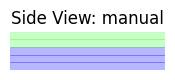

['white', 'white', 'blue', 'green', 'black']


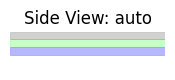

In [43]:
import numpy as np
from skimage import color
import matplotlib.pyplot as plt

# --- UTILITY FUNCTIONS ---
def clamp(lb, ub, val):
    return min(max(lb, val), ub)

def rgb_to_lab(rgb):
    rgb = np.array(rgb).reshape(1, 1, 3)
    lab = color.rgb2lab(rgb)
    return lab[0, 0]

def lab_to_rgb(lab):
    lab = np.array(lab).reshape(1, 1, 3)
    rgb = color.lab2rgb(lab)
    return rgb[0, 0]

def alpha_from_td(thickness, td):
    """
    Convert thickness (mm) and transmission distance (mm) to an opacity:
      alpha = 1 - exp(-thickness / td)
    """
    return 1 - np.exp(-thickness / td)

def composite_over(base_rgb, top_rgb, top_alpha):
    base_rgb = np.array(base_rgb, dtype=np.float64)
    top_rgb = np.array(top_rgb, dtype=np.float64)

    return top_alpha * top_rgb + (1 - top_alpha) * base_rgb

def color_distance(rgb1, rgb2):
    rgb1 = np.array(rgb1).reshape(1, 1, 3)
    rgb2 = np.array(rgb2).reshape(1, 1, 3)
    lab1 = color.rgb2lab(rgb1)
    lab2 = color.rgb2lab(rgb2)

    # Euclidean distance in LAB space
    return np.linalg.norm(lab1 - lab2)


# --- GLOBAL ---
filaments = {
    'black': {
        'rgb': [0.0, 0.0, 0.0],
        'td': 0.5,   # Transmission Distance in mm
    },
    'blue': {
        'rgb': [0.0, 0.0, 1.0],
        'td': 0.3,
    },
    'green': {
        'rgb': [0.0, 1.0, 0.0],
        'td': 0.4,
    },
    'red': {
        'rgb': [1.0, 0.0, 0.0],
        'td': 0.2,
    },
    'white': {
        'rgb': [1.0, 1.0, 1.0],
        'td': 0.7,
    },
}

layer_thickness = 0.1  # mm per layer
base_color = [0.5, 0.5, 0.5]  # white background
target_color = [0.0, 0.5, 0.5]  # custom teal


# --- SETUP ---
colors = {} # {"rgb", "alpha"}
for f_name, f in filaments.items():
    rgb = f['rgb']
    td = f['td']
    alpha = alpha_from_td(layer_thickness, td)
    colors[f_name] = {
        "rgb": rgb,
        "alpha": alpha
    }

print(colors)

# 6) Blend layer by layer using TD-based alpha
def blend_layers(layers):
    current_rgb = np.array(base_color, dtype=float)
    for i, name in enumerate(layers, start=1):
        rgb = np.array(colors[name]['rgb'], dtype=float)
        alpha = colors[name]['alpha']
        current_rgb = composite_over(current_rgb, rgb, alpha)

    return current_rgb


def blend_layers_alpha(layers):
    current_rgb = np.array([0.0, 0.0, 0.0], dtype=float)
    current_alpha = 0.0

    for name in layers:
        rgb = np.array(colors[name]['rgb'], dtype=float)
        alpha = float(colors[name]['alpha'])

        current_rgb = rgb * alpha + current_rgb * (1 - alpha)
        current_alpha = alpha + current_alpha * (1 - alpha)
    
    return [current_rgb / current_alpha, current_alpha]

# 7) Show a side-by-side comparison of blended vs. target
def print_comparasion(rgb1, rgb2):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(4, 2))
    dist1 = round(color_distance(rgb1, target_color), 2)
    ax1.imshow(np.ones((10,10,3)) * rgb1.reshape((1,1,3)))
    ax1.set_title(f"Manual, dist: {dist1}")

    ax2.imshow(np.ones((10,10,3)) * np.array(target_color).reshape((1,1,3)))
    ax2.set_title("Target")
    
    dist2 = round(color_distance(rgb2, target_color), 2)
    ax3.imshow(np.ones((10,10,3)) * rgb2.reshape((1,1,3)))
    ax3.set_title(f"Auto, dist: {dist2}")

    for ax in (ax1, ax2, ax3):
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 8) Visualize each layer from the side with uniform thickness
def visualize_stack(stack, title):
    print(stack)
    total_thickness = layer_thickness * len(stack)
    fig2, ax2 = plt.subplots(figsize=(2, total_thickness))
    y_bottom = 0
    for i, name in enumerate(stack, start=1):
        rgb = colors[name]['rgb']
        alpha = colors[name]['alpha']
        rect = plt.Rectangle(
            (0, y_bottom), 1, layer_thickness,
            color=(rgb[0], rgb[1], rgb[2], alpha),
            edgecolor='black',
            linewidth=0.5
        )
        ax2.add_patch(rect)
        y_bottom += layer_thickness

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, total_thickness)
    ax2.set_aspect('auto')
    ax2.axis('off')
    ax2.set_title(title)

    plt.tight_layout()
    plt.show()


def get_stack(max_layers):
    curr_stack = []
    best_stack = []
    best_distance = color_distance(base_color, target_color)
    best_color_dist = 1000000
    print("target")
    print(target_color)
    print("base", best_distance)
    print(base_color)

    for i in range(max_layers):

        for c_name, c in colors.items():
            new_stack = list(curr_stack)
            new_stack.insert(0, c_name)

            blend = blend_layers(new_stack)
            dist = color_distance(blend, target_color)

            print(c_name, dist)
            color_dist, closest_dist = get_stack_potential(new_stack)
            print(new_stack)
            print(color_dist)
            print(closest_dist)

            if(dist < best_distance and closest_dist < best_distance):
                best_distance = dist
                best_stack = list(new_stack)
        
        curr_stack = list(best_stack)
        print(curr_stack)
    
    return curr_stack
            
            
    


def get_stack_potential(stack):

    rgb, alpha = blend_layers_alpha(stack)

    min_color = composite_over([0.0, 0.0, 0.0], rgb, alpha)
    max_color = composite_over([1.0, 1.0, 1.0], rgb, alpha)

    
    color_dist = color_distance(rgb, target_color)
    closest_color = [
        clamp(min_color[0], max_color[0], target_color[0]),
        clamp(min_color[1], max_color[1], target_color[1]),
        clamp(min_color[2], max_color[2], target_color[2]),
    ]
    closest_dist = color_distance(closest_color, target_color)

    return [color_dist, closest_dist]








# --- DO STUFF ---



stack_manual = ['blue'] * 3 + ['green'] * 2
stack_auto = get_stack(5)

blended_manual = blend_layers(stack_manual)
blended_auto = blend_layers(stack_auto)

print_comparasion(blended_manual, blended_auto)

visualize_stack(stack_manual, "Side View: manual")
visualize_stack(stack_auto, "Side View: auto")